# Compute empirical distribution instead of training in few-data case

No training; Use empirical distribution to replace score function;

1. Load 1 image;
2. Compute empirical distribution, at time t;
3. Loop from T to 0 to generate;


Terminology:

+ Red font or box means questionble parts.
+ N1M1 dataset, "N-sample-M-dim dataset", 
  - One image (128x128x3): N1M(128x128x3) $\approx$ N1M50k;
  - 1000 floats: N(1000)M1 = N10kM1;
+ ETM, "Experimental Theory Mismatch"

We denote:
- the forward process as $X(t)$, begin at $X(0)=X_0$ and end at $X(1)$; 
- the backward process as $\bar{X}(s)$, begin at $\bar{X}(0)$ and end at $\bar{X}(1)$
  
1. introduce Brownian motion, 
   - $dX(t)=dW(t)$
   - the simplest model:
   - A gaussian process, the $p(x,x',t')$ is explicit.
   - Forward/backward SDE is known.
   - ONLY backward SDE matters since we compute the score function by empirical distribution of dataset;
   - Case N10kM1 dataset, sampling algorithm;
   - Case N1M(128x128x3) dataset, sampling algorithm;
   - [$\color{red}{\text{ETM}}$]Though the forward-end $X(1)$ is $N(X_0,I)$, but the bacward-begin $\bar{X}(0)$ works in practice and converge to exact $X_0$ with increasing $S$(number of steps).
   - [*Later*]Case 2img and kimg-dataset, sampling algorithm;

2. Another gaussian process, with $X(1)=\mathcal{N}(0,I)$.
   - $dX(t) = \alpha X(t)dt + \beta dW(t)$
   - Find the reverse SDE following the derivation of Brownian motion;

3. Geometry Brownian motion,
   - $dX(t) = \alpha X(t)dt + \beta X(t)dW(t)$

## Introduction

In [58]:
import numpy as np
from pathlib import Path
from MyDDPM.apps.rennet import call_by_inspect
img_size = 128  # 如果只想快速实验，可以改为64

logdir = Path("/home/tjrym/workspace/DDPM-SuJL/Results","ddpm2_emp_sample")
logdir.mkdir(parents=True,exist_ok=True)
logdir = logdir.as_posix()

# 超参数选择
T = 100000
alpha = np.sqrt(1 - 0.02 * np.arange(1, T + 1) / T)
beta = np.sqrt(1 - alpha**2)
bar_alpha = np.cumprod(alpha)
bar_beta = np.sqrt(1 - bar_alpha**2)
sigma = beta.copy()

config = dict(locals())

In [4]:
from MyDDPM.apps.ddpm2 import get_imgs

imgs = get_imgs(["CelebAHQ256_1"])
print("- imgs: ")
print(len(imgs))
print(imgs[0])

- imgs: 
64
/home/tjrym/workspace/Dataset/CelebAHQ_1/00001 (58).jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


- x0
-- shape: (128, 128, 3)
-- min,max: -1.0 0.94509804
-- mean,std: -0.13055842 0.5814528


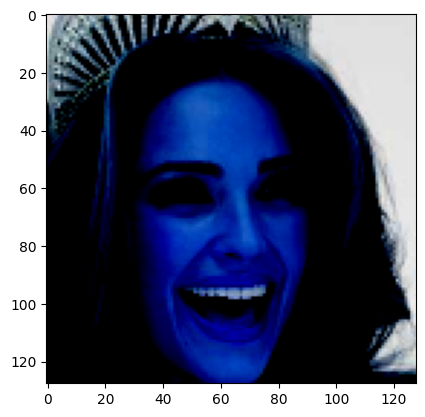

In [5]:
from MyDDPM.apps.ddpm2_h import imread
from matplotlib import pyplot as plt
x0 = imread(imgs[0],img_size)

print("- x0")
print("-- shape:",x0.shape)
print("-- min,max:",x0.min(),x0.max())
print("-- mean,std:",x0.mean(),x0.std())
plt.imshow(x0)
plt.show()

## Brownian motion SDE 
> 1img
> Initial value not 0.

For $t \in [0,1]$,
$$
dX(t) = dW(t),\\
X(0)=X_0
$$


Notice we have :
- time $t \in [0,1]$, $X(1)$ is $\mathcal{N}(X(0),I)$ instead of $\mathcal{N}(0,I)$ (like DDPM), in the forward process;
- time $s \in [0,1]$ in backward process, start from $s=0$.
- $X_0=$ image, range $[-1,1]$ of shape $(\text{batch\_size}, H,W,3)$



Assume noise on each pixel are iid Gaussian,


**The SDE**:

$$
\begin{align}
\left\{ \begin{aligned}
dX(t) = dW(t),\\
X(0) = X_0\\

\end{aligned}\right.
\end{align}
$$

Notice:
- $X(t) \sim \mathcal{N}(X_0,tI)$, then
- $X(1) \sim \mathcal{N}(X_0,I)$.

Later we will derive a version of $X(1) \sim \mathcal(0,I)$, which is'ore close to original DDPM. Since we compute score function based on Data, so sampling start from a dist related to data is OK.


**Transition (here refer to the conditional distribution)**:

Load an image as HWC, (C=3). Use $x^i(k)$ for k-th pixel of i-th image in dataset; $\pi_0$ is the probabilty measure of all-data. Here we replace it with empirical distribution of N-sample dataset, that is, each sample have same weight.

$$
\begin{align}
\begin{aligned}
    p(x,t) &= \int_\mathbb{R} p(x,t|x',0) \pi_0(dx')\\
           &= \frac{1}{N} \sum_{i=1}^{N} p(x,t|x^i,0)
\end{aligned}
\end{align}
$$

$$
p(x,t|x',t') = \frac{1}{\sqrt{2 \pi (t-t')}}\exp\left(\frac{(x-x')^2}{-2(t-t')}\right),~ t>t'
$$ 
i.e.,
$$
x = x' + \sqrt{t-t'}\varepsilon,~ \varepsilon \sim\mathcal{N}(0,1)
$$

then $X(1) \sim p(x,1)$.

Case $N=1$, ${x^i}_{i=0}^{N}={x^0}$,i.e., $x'=x^0$, $t'=0$ and $p(x^0,0)=1$.
$$
\begin{align}
p(x,t)= 1*p(x,t|x^0,0) = \frac{1}{\sqrt{2 \pi t}}\exp\left(\frac{(x-x^0)^2}{-2t}\right)\\

\end{align}
$$


### Wrong but work
- `sample_1`, `run_1`
- start from N(0,1) instead of p(x,1)
- 1img case;


The reverse SDE, $s \in [0,1]$:

$$
\begin{align}
\left\{
    \begin{aligned}
    d\bar{X}(s) = \frac{\partial}{\partial x} \log p(\bar{X}(s), 1-s)dt + d\bar{W}(s)\\
    \bar{X}(0) \sim  = \mathcal{N}(0,I) \neq\colorbox{red}{  p(x,1)},\\
\end{aligned}\right.
\end{align}
$$

where

$$
\frac{\partial}{\partial x} \log p(x,t) = \frac{(x-x^0)}{-t}
$$

The sampling, for $s=0,1/S,2/S,\cdots,(S-1)/S$:

$$
\begin{align}
\left\{ \begin{aligned}
    \bar{x}(s+1/S) :=\bar{x}(s) -\frac{x(s)-x^0}{1-s} + \sqrt{1-s} \bar{\varepsilon}(s),~ \bar{\varepsilon}(s) \sim \mathcal{N}(0,I)\\
    \bar{x}(0) \sim \mathcal{N}(0,I)
\end{aligned} \right.
\end{align}
$$

then $\bar{x}_S \approx \bar{x}(1)$ is a new image;  

<div style="border: 2px solid black; padding: 10px; font-weight: bold;">
    <font color="red">#BUG #FIXME #NOTICE #TODO</font>

    In the following script we start sampling with N(0,I) which is not corresponding p(x,1)=N(x^0,I).

    Though the script works well and converge by increasing T ... ...
    
    BUT IT IS theorictially WRONG. BUT WHY?? 
</div>




100% 2000/2000 [00:02<00:00, 903.42it/s]


- T= 2000
- y0 min/max:  -1.0 0.986255938635338
- mse:  0.0004971503234575274
Human friendly (RGB)


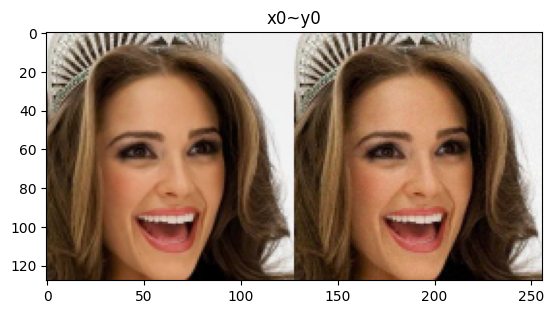

In [87]:
from tqdm import tqdm
def sample_1(x0,T,n):
    
    y_states = []
    y = np.random.randn(n, img_size, img_size, 3) # xT
    x0 = x0[np.newaxis,:]
    t_old = 0/T
    for i in tqdm(range(T), ncols=0):
        t = (i+1)/T # (1,...,T)/T
        # score_func_1
        sf=  -(y-x0)/(1-t_old)
        y += sf *(t-t_old) + np.sqrt(t-t_old)* np.random.randn(*y.shape)
        y_states.append(y)
        t_old = t
    
    return y_states

from matplotlib import pyplot as plt
import cv2

def run_1(x0, T, n, n_show,*,nodisp=False):
    assert n_show<=n
    y_states = sample_1(x0, T=T , n=n)

    y0 = y_states[-1]
    y0 = np.clip(y0, -1, 1)
    print("- T=",T)
    print("- y0 min/max: ", y0.min(), y0.max())
    err = np.sum((y0-x0)**2)/y0.size
    print("- mse: ", err)
    
    if n_show>0:
        rows = []
        for i in range(n_show):
            # plt.figure()
            # plt.title("BGR(cv2 default)")
            # plt.imshow(y0[i])
            # plt.show()
            row = np.concatenate([
            cv2.cvtColor((x0+1)/2, cv2.COLOR_BGR2RGB),
            cv2.cvtColor((y0[i].astype("float32")+1)/2, cv2.COLOR_BGR2RGB)
            ],axis=1)
            rows.append(row)
        figure = np.concatenate(rows,axis=0)

    
        from matplotlib import pyplot as plt
        print("Human friendly (RGB)")
        plt.figure()
        plt.title("x0~y0")
        plt.imshow(figure)
        if not nodisp:
            plt.show()
        else:
            plt.close()

    return y_states, err

_ = run_1(x0,T=2000,n=2,n_show=1)


With increasing $S$, we measure the average-L2 loss between $x^0$ and $\bar{x}^0$.

100% 100/100 [00:00<00:00, 207.55it/s]


- T= 100
- y0 min/max:  -1.0 1.0
- mse:  0.009467088937160736


100% 200/200 [00:00<00:00, 217.19it/s]


- T= 200
- y0 min/max:  -1.0 1.0
- mse:  0.004817797421198263


100% 300/300 [00:01<00:00, 218.21it/s]


- T= 300
- y0 min/max:  -1.0 1.0
- mse:  0.0032707542078882143


100% 400/400 [00:01<00:00, 217.46it/s]


- T= 400
- y0 min/max:  -1.0 1.0
- mse:  0.002452542838023914


100% 500/500 [00:02<00:00, 216.42it/s]


- T= 500
- y0 min/max:  -1.0 1.0
- mse:  0.0019743614259321086


100% 600/600 [00:02<00:00, 217.97it/s]


- T= 600
- y0 min/max:  -1.0 1.0
- mse:  0.0016453361816963817


100% 700/700 [00:03<00:00, 214.37it/s]


- T= 700
- y0 min/max:  -1.0 1.0
- mse:  0.0014049721706579598


100% 800/800 [00:03<00:00, 214.38it/s]


- T= 800
- y0 min/max:  -1.0 1.0
- mse:  0.0012283876758176972


100% 900/900 [00:04<00:00, 211.46it/s]


- T= 900
- y0 min/max:  -1.0 1.0
- mse:  0.0011034517160913883


100% 1000/1000 [00:04<00:00, 216.79it/s]


- T= 1000
- y0 min/max:  -1.0 1.0
- mse:  0.0009874666151959365


100% 1100/1100 [00:05<00:00, 216.81it/s]


- T= 1100
- y0 min/max:  -1.0 1.0
- mse:  0.0008978764452397327


100% 1200/1200 [00:05<00:00, 217.18it/s]


- T= 1200
- y0 min/max:  -1.0 1.0
- mse:  0.0008253292120488603


100% 1300/1300 [00:05<00:00, 216.84it/s]


- T= 1300
- y0 min/max:  -1.0 1.0
- mse:  0.0007602096717389622


100% 1400/1400 [00:06<00:00, 216.18it/s]


- T= 1400
- y0 min/max:  -1.0 1.0
- mse:  0.0007065072248958964


100% 1500/1500 [00:06<00:00, 215.68it/s]


- T= 1500
- y0 min/max:  -1.0 0.9930526326326147
- mse:  0.0006592475515666822


100% 1600/1600 [00:07<00:00, 218.20it/s]


- T= 1600
- y0 min/max:  -1.0 0.9956788444900215
- mse:  0.0006208168349184672


100% 1700/1700 [00:07<00:00, 217.86it/s]


- T= 1700
- y0 min/max:  -1.0 1.0
- mse:  0.0005832391035657144


100% 1800/1800 [00:08<00:00, 216.52it/s]


- T= 1800
- y0 min/max:  -1.0 0.9990044718268131
- mse:  0.0005507802692014075


100% 1900/1900 [00:08<00:00, 217.64it/s]


- T= 1900
- y0 min/max:  -1.0 0.9854486242528027
- mse:  0.0005228725082180902


100% 2000/2000 [00:09<00:00, 217.77it/s]


- T= 2000
- y0 min/max:  -1.0 0.9881709427063443
- mse:  0.0004976052009127025


100% 2100/2100 [00:09<00:00, 219.31it/s]


- T= 2100
- y0 min/max:  -1.0 1.0
- mse:  0.0004722287330042577


100% 2200/2200 [00:10<00:00, 217.03it/s]


- T= 2200
- y0 min/max:  -1.0 0.9978951147414079
- mse:  0.00044992176492054703


100% 2300/2300 [00:10<00:00, 218.00it/s]


- T= 2300
- y0 min/max:  -1.0 0.9944941709768408
- mse:  0.00042976875782864085


100% 2400/2400 [00:11<00:00, 215.49it/s]


- T= 2400
- y0 min/max:  -1.0 0.9913533887189738
- mse:  0.0004119418953651912


100% 2500/2500 [00:11<00:00, 215.83it/s]


- T= 2500
- y0 min/max:  -1.0 0.9742468165094957
- mse:  0.00039848637513253634


100% 2600/2600 [00:11<00:00, 217.58it/s]


- T= 2600
- y0 min/max:  -1.0 0.9778260272169277
- mse:  0.00038154488852487194


100% 2700/2700 [00:12<00:00, 218.11it/s]


- T= 2700
- y0 min/max:  -1.0 0.9813402980165548
- mse:  0.00036680468151164934


100% 2800/2800 [00:12<00:00, 219.02it/s]


- T= 2800
- y0 min/max:  -1.0 0.98978662486591
- mse:  0.00035451495239087125


100% 2900/2900 [00:13<00:00, 216.46it/s]


- T= 2900
- y0 min/max:  -1.0 0.9928773337426868
- mse:  0.0003421177287648741


100% 3000/3000 [00:13<00:00, 217.30it/s]


- T= 3000
- y0 min/max:  -1.0 0.9829775894131618
- mse:  0.0003310121149161874


100% 3100/3100 [00:14<00:00, 218.09it/s]


- T= 3100
- y0 min/max:  -1.0 0.9779964821454923
- mse:  0.00032038036438378795


100% 3200/3200 [00:14<00:00, 217.37it/s]


- T= 3200
- y0 min/max:  -1.0 0.972834019583992
- mse:  0.0003104306708289534


100% 3300/3300 [00:15<00:00, 217.59it/s]


- T= 3300
- y0 min/max:  -1.0 0.988655319926431
- mse:  0.000299998390413677


100% 3400/3400 [00:15<00:00, 217.34it/s]


- T= 3400
- y0 min/max:  -1.0 0.9914931382453777
- mse:  0.00029239969692941163


100% 3500/3500 [00:16<00:00, 216.48it/s]


- T= 3500
- y0 min/max:  -1.0 0.9778351470047649
- mse:  0.0002843387965213062


100% 3600/3600 [00:16<00:00, 217.11it/s]


- T= 3600
- y0 min/max:  -1.0 0.9836979263691193
- mse:  0.0002766028110023491


100% 3700/3700 [00:17<00:00, 215.88it/s]


- T= 3700
- y0 min/max:  -1.0 0.9866392364958759
- mse:  0.0002675519397165191


100% 3800/3800 [00:17<00:00, 216.74it/s]


- T= 3800
- y0 min/max:  -1.0 0.9690835069356029
- mse:  0.00026146051713261986


100% 3900/3900 [00:17<00:00, 217.37it/s]


- T= 3900
- y0 min/max:  -1.0 0.9719846360166418
- mse:  0.0002552571615945074


100% 4000/4000 [00:18<00:00, 218.23it/s]

- T= 4000
- y0 min/max:  -1.0 0.9804081677951648
- mse:  0.00024890633639215444


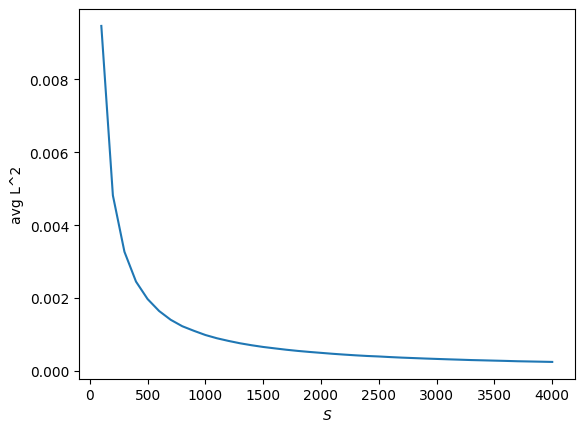

In [91]:
count = 40
step = 100
T_l =[(j+1)*step for j in range(count)]
err_l = []
for j,T in enumerate(T_l):
    _,err = run_1(x0,T=T,n=8,n_show=0)
    err_l.append(err)

plt.figure()
plt.plot(T_l, err_l)
plt.xlabel("$S$")
plt.ylabel("avg $L^2$")
plt.show()


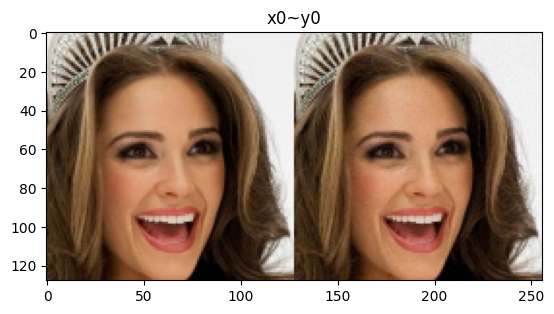

### Corrected
- 1img
- Use p(x,1) 


Next, We try to start from $\bar{X}(s=0):=p(x,1)=N(x^0,I)$ instead of $N(0,I)$. 

100% 2000/2000 [00:02<00:00, 908.22it/s]


- T= 2000
- y0 min/max:  -1.0 0.9789550311215887
- mse:  0.0004941248448457057
Human friendly (RGB)


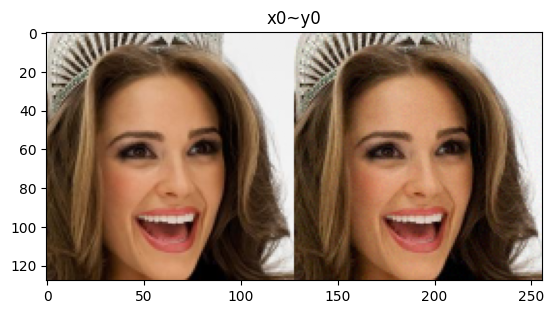

In [13]:
from tqdm import tqdm


def score_function_2(t,x,x0):
    return -(x-x0)/(t)

def sample_2(x0,T,n):
    
    y_states = []
    y = np.random.randn(n, img_size, img_size, 3) + x0 # xT
    x0 = x0[np.newaxis,:]
    t_old = 0/T
    for i in tqdm(range(T), ncols=0):
        t = (i+1)/T # (1,...,T)/T
        # score_func_1
        sf=  score_function_2((1-t_old),y,x0)
        y += sf *(t-t_old) + np.sqrt(t-t_old)* np.random.randn(*y.shape)
        y_states.append(y)
        t_old = t
    
    return y_states

from matplotlib import pyplot as plt
import cv2

def run_2(x0, T, n, n_show,*,nodisp=False):
    assert n_show<=n
    y_states = sample_2(x0, T=T , n=n)

    y0 = y_states[-1]
    y0 = np.clip(y0, -1, 1)
    print("- T=",T)
    print("- y0 min/max: ", y0.min(), y0.max())
    err = np.sum((y0-x0)**2)/y0.size
    print("- mse: ", err)
    
    if n_show>0:
        rows = []
        for i in range(n_show):
            # plt.figure()
            # plt.title("BGR(cv2 default)")
            # plt.imshow(y0[i])
            # plt.show()
            row = np.concatenate([
            cv2.cvtColor((x0+1)/2, cv2.COLOR_BGR2RGB),
            cv2.cvtColor((y0[i].astype("float32")+1)/2, cv2.COLOR_BGR2RGB)
            ],axis=1)
            rows.append(row)
        figure = np.concatenate(rows,axis=0)

    
        from matplotlib import pyplot as plt
        print("Human friendly (RGB)")
        plt.figure()
        plt.title("x0~y0")
        plt.imshow(figure)
        if not nodisp:
            plt.show()
        else:
            plt.close()

    return y_states, err

_ = run_2(x0,T=2000,n=2,n_show=1)


### 3. kimg case; Wrong start for reverse
- start from N(0,1)

In [7]:
from MyDDPM.apps.ddpm2 import get_imgs

imgs = get_imgs(["CelebAHQ256"])
print("- imgs: ")
print(len(imgs))
print(imgs[0])

- imgs: 
13033
/home/tjrym/workspace/Dataset/CelebAHQ/data256x256/12620.jpg


100% 1000/1000 [00:06<00:00, 149.36it/s]


- T= 1000
- y0 min/max:  -1.0 1.0
- mse:  0.31218770799495016
Human friendly (RGB)


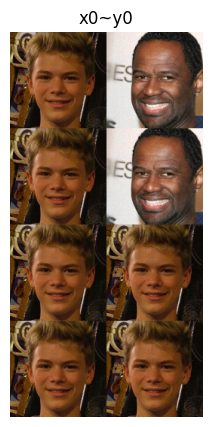

In [59]:
def make_data_3(imgs, N):
    data = np.array([imread(imgs[i],img_size) for i in range(N)])
    return data

def score_function_3(t, x, data:np.ndarray):
    """data: NHW3
    x:BHW3
    """
    N = data.shape[0]

    data_ = data[np.newaxis,:,:,:,:] # 1NHW3
    x_ = x[:,np.newaxis,:,:,:] # B1HW3
    g = (x_-data_)**2 # BNHW3
    g_ = np.sum(g,axis=-1,keepdims=True)
    g_ = np.sum(g_,axis=-2,keepdims=True)
    h = np.sum(g_,axis=-3,keepdims=True)# BN111
    hmax = np.max(h,axis=1,keepdims=True)# B1111
    v = np.sum( np.exp(h-hmax)*(x_-data_)/(-t), axis=1) # BHW3
    v =  v/np.sum(np.exp(h-hmax),axis=1)

    if data.shape[0]==1:
        assert np.sum(v - (x-data)/(-t))<1e-6, f"{np.sum(v)},\n{np.sum((x-data)/(-t))}"
    

    return v

from tqdm import tqdm
def sample_3(data,T,n):
    
    y_states = []
    x0 = data[0:n,:,:,:]
    y = np.random.randn(n, img_size, img_size, 3) + 0 # xT
    x0 = x0[np.newaxis,:]
    t_old = 0/T
    for i in tqdm(range(T), ncols=0):
        t = (i+1)/T # (1,...,T)/T
        # score_func_1
        sf=  score_function_3(1-t_old,y,data)
        y += sf *(t-t_old) + np.sqrt(t-t_old)* np.random.randn(*y.shape)
        y_states.append(y)
        t_old = t
    
    return y_states

from matplotlib import pyplot as plt
import cv2

def run_3(N, T, n, n_show,*,nodisp=False):
    data = make_data_3(imgs,N)
    x0 = data[0]
    assert n_show<=n
    y_states = sample_3(data, T=T , n=n)

    y0 = y_states[-1]
    y0 = np.clip(y0, -1, 1)
    print("- T=",T)
    print("- y0 min/max: ", y0.min(), y0.max())
    err = np.sum((y0-x0)**2)/y0.size
    print("- mse: ", err)
    
    if n_show>0:
        rows = []
        for i in range(n_show):
            # plt.figure()
            # plt.title("BGR(cv2 default)")
            # plt.imshow(y0[i])
            # plt.show()
            row = np.concatenate([
            cv2.cvtColor((x0+1)/2, cv2.COLOR_BGR2RGB),
            cv2.cvtColor((y0[i].astype("float32")+1)/2, cv2.COLOR_BGR2RGB)
            ],axis=1)
            rows.append(row)
        figure = np.concatenate(rows,axis=0)

    
        from matplotlib import pyplot as plt
        print("Human friendly (RGB)")
        plt.figure(figsize=(round(figure.shape[0]/50),round(figure.shape[1]/50)))
        plt.title("x0~y0")
        plt.axis("off")
        plt.imshow(figure)
        plt.imsave(Path(logdir,"run_3__N{N}T{T}n{n}.png").as_posix(),figure)
        if not nodisp:
            plt.show()
        else:
            plt.close()

    return y_states, err

_ = run_3(N=4,T=1000,n=4,n_show=4)

100% 600/600 [04:49<00:00,  2.07it/s]

- T= 600
- y0 min/max:  -1.0 1.0
- mse:  0.7345594616054145
Human friendly (RGB)


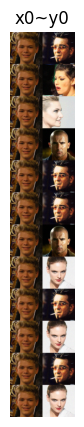

In [56]:
_ = run_3(N=100,T=600,n=12,n_show=12)

## Geometric Brownian motion SDE 
> 1img
> $\mu=0,\sigma=1$

[Wiki-zh](https://zh.wikipedia.org/wiki/%E5%87%A0%E4%BD%95%E5%B8%83%E6%9C%97%E8%BF%90%E5%8A%A8)
[Wiki-en](https://en.wikipedia.org/wiki/Geometric_Brownian_motion)

$$
\begin{align}
dX(t) &= \mu X(t)dt + \sigma X(t) dW(t), \\
X(0)  &= X_0
\end{align}
$$

where $W(t)$ is Wiener process.

**Basic properties:**

At time t,
$$
\mathbb{E}[X] = X_0e^{\mu t},\\
\mathop{Var}[X]=X_0^2 e^{2\mu t}(e^{\sigma^2 t}-1)
$$

Use $\mu=0,\sigma=1$,

$$
\mathbb{E}[X(t)] = X_0,\\
\mathop{Var}[X(t)] = X_0^2(e^t-1)
$$
and 
$$
\mathop{Var}[X(0)] = 0,\\
\mathop{Var}[X(1)] = X_0^2(e-1)
$$